In [1]:
# # Nếu chưa có thư viện thì run cell này
# !pip install mediapipe
# !pip install pandas
# !pip install numpy

# 1. Import and Install Dependencies

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


<class 'mediapipe.python.solution_base.SolutionOutputs'>


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/nhamcotdo/.local/lib/python3.10/site-packages/cv2/qt/plugins"


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

# 3. Setup Folders for Collection

In [7]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('./Data')

# Actions that we try to detect
actions = np.array(
    ['Bye', 'Fine', 'Good', 'Hello', 'I', 'You']
    )

# Path for exported data, numpy arrays
DATASET_PATH = os.path.join('./Data')

sequence_length = 10


# 4. Extract Keypoint Values

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*4)
    rh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*4)
    return np.concatenate([pose, lh, rh])

In [9]:
def frames_extraction(video_path, rev=False):
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = 0
    s, f = video_reader.read()
    while s:
        s, f = video_reader.read()
        video_frames_count += 1
    video_reader.release()

    # ĐỌc video

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/sequence_length), 1)

    # Danh sách chứa các frame sẽ lấy
    video_keypoints = []

    cap = cv2.VideoCapture(video_path)
    # Iterate through the Video Frames.
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        for frame_counter in range(sequence_length):
            cap.set(cv2.CAP_PROP_POS_FRAMES,
                    frame_counter * skip_frames_window)
            
            ret, frame = cap.read()
            if rev:
                frame = cv2.flip(frame, 1)

            if not ret:
                # cap = cv2.VideoCapture(video_path)
                print('eror')
                continue
                # break

            # resize image to half its original size
            image, results = mediapipe_detection(frame, holistic)
            draw_styled_landmarks(image, results)   

            keypoints = extract_keypoints(results)
            video_keypoints.append(keypoints)
            # Flip the image2 horizontally for a selfie-view display.
            cv2.imshow('OpenCV Feed', cv2.flip(image, 1))
            if cv2.waitKey(1) == ord('e'):
                return

    # Release the VideoCapture object.
    # Return the frames list.
    return video_keypoints


In [11]:
rs = frames_extraction('./Data/Bye/video104198.avi')
cv2.destroyAllWindows()


In [12]:
np.shape(rs)

(10, 300)

# 5. Collect Keypoint Values for Training and Testing

In [13]:
def create_dataset():
    features = []
    labels = []

    for class_index, class_name in enumerate(actions):
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATA_PATH, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:
            # print(file_name)
            try:
                # Get the complete video path.
                video_file_path = os.path.join(
                    DATA_PATH, class_name, file_name)

                # Extract the frames of the video file.
                video_keypoints = frames_extraction(video_file_path)

                # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
                # So ignore the vides having frames less than the SEQUENCE_LENGTH.
                if len(video_keypoints) == sequence_length:
                    features.append(video_keypoints)
                    labels.append(class_index)
                
                video_file_path = os.path.join(
                    DATA_PATH, class_name, file_name)

                # # Extract the frames of the video file.
                # video_keypoints = frames_extraction(video_file_path, rev=1)

                # # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
                # # So ignore the vides having frames less than the SEQUENCE_LENGTH.
                # if len(video_keypoints) == sequence_length:
                #     features.append(video_keypoints)
                #     labels.append(class_index)
            except:
                continue

        cv2.destroyAllWindows()


    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels


In [14]:
features, labels = create_dataset()
np.savez_compressed(f'{DATASET_PATH}/data.npz', features=features, labels=labels)


Extracting Data of Class: Bye
Extracting Data of Class: Fine
eror
eror
Extracting Data of Class: Good
eror
Extracting Data of Class: Hello
Extracting Data of Class: I
eror
eror
eror
Extracting Data of Class: You


# 6. Preprocess Data and Create Labels and Features

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

2023-04-07 16:00:10.312066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 16:00:11.209860: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nhamcotdo/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-04-07 16:00:11.209891: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-07 16:00:13.203612: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dl

In [20]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'Bye': 0, 'Fine': 1, 'Good': 2, 'Hello': 3, 'I': 4, 'You': 5}

In [21]:
data = np.load(f'./{DATASET_PATH}/data.npz')
X = data['features']
labels = data['labels']

In [22]:
X.shape

(260, 10, 300)

In [23]:
y = to_categorical(labels).astype(int)

In [24]:
y.shape

(260, 6)

(array([4., 4., 5., 5., 4., 4.]),
 array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
        4.16666667, 5.        ]),
 <BarContainer object of 6 artists>)

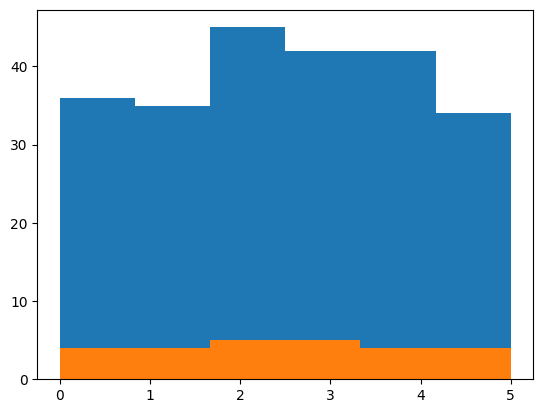

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define the splitter
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

# Get the indices for splitting
train_idx, test_idx = next(splitter.split(X, y))

# Split the data into train and test sets
X_train = X[train_idx]
X_test = X[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]
plt.hist(np.argmax(y_train, 1), bins=6, label=label_map)
plt.hist(np.argmax(y_test, 1), bins=6, label=label_map)

# 7. Build and Train LSTM Neural Network

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [28]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(sequence_length,X.shape[-1])))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

2023-04-07 16:00:40.763355: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nhamcotdo/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-04-07 16:00:40.764408: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-07 16:00:40.764502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nhamcotdo): /proc/driver/nvidia/version does not exist
2023-04-07 16:00:40.766670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate com

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            93440     
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 248,102
Trainable params: 248,102
Non-trai

In [31]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [39]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
early_stopping_callback_acc = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)
model_history = model.fit(x = X_train, y = y_train, epochs = 500, shuffle = True, validation_data=[X_test, y_test], batch_size=1, callbacks = [tb_callback])

Epoch 1/500
234/234 [==============================] - 3s 12ms/step - loss: 3.7597e-07 - categorical_accuracy: 1.0000 - val_loss: 0.8334 - val_categorical_accuracy: 0.9231
Epoch 2/500
234/234 [==============================] - 3s 11ms/step - loss: 3.1585e-07 - categorical_accuracy: 1.0000 - val_loss: 0.8246 - val_categorical_accuracy: 0.9231
Epoch 3/500
234/234 [==============================] - 3s 12ms/step - loss: 0.1724 - categorical_accuracy: 0.9872 - val_loss: 2.2376 - val_categorical_accuracy: 0.6154
Epoch 4/500
234/234 [==============================] - 2s 9ms/step - loss: 23.4658 - categorical_accuracy: 0.7393 - val_loss: 0.7507 - val_categorical_accuracy: 0.7308
Epoch 5/500
234/234 [==============================] - 2s 9ms/step - loss: 0.3131 - categorical_accuracy: 0.8761 - val_loss: 0.1642 - val_categorical_accuracy: 0.9615
Epoch 6/500
234/234 [==============================] - 2s 9ms/step - loss: 1.5541 - categorical_accuracy: 0.8846 - val_loss: 0.1533 - val_categorical_acc

In [42]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 42ms/step - loss: 0.0788 - categorical_accuracy: 0.9615


[0.07878678292036057, 0.9615384340286255]

In [43]:
path_weight = f'weights_{time.time()}.h5'
import time
model.save(path_weight)

# 10. Evaluation using Confusion Matrix and Accuracy

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [45]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name, color_1='blue', color_2='red'):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, color_1, label = metric_name_1)
    plt.plot(epochs, metric_value_2, color_2, label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

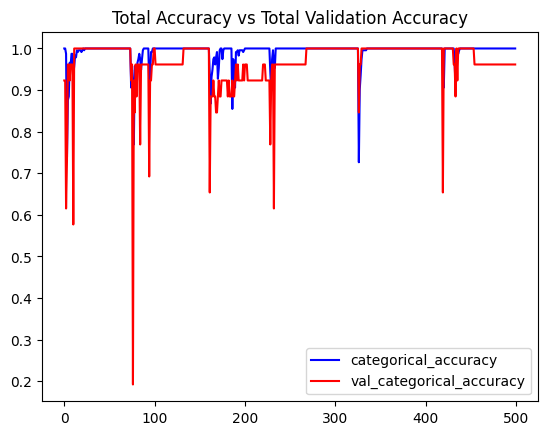

In [46]:
plot_metric(model_history, 'categorical_accuracy', 'val_categorical_accuracy', 'Total Accuracy vs Total Validation Accuracy')

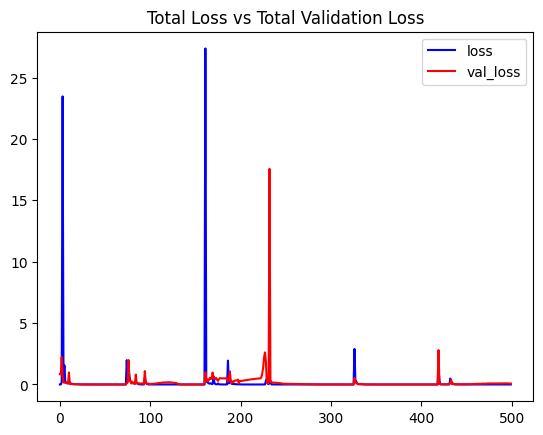

In [47]:
plot_metric(model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [48]:
model = tf.keras.models.load_model(path_weight)
yhat = model.predict(X_test)

1/1 [==============================] - 0s 483ms/step


In [49]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
accuracy_score(y_true=ytrue, y_pred=yhat)


0.9615384615384616

<Axes: >

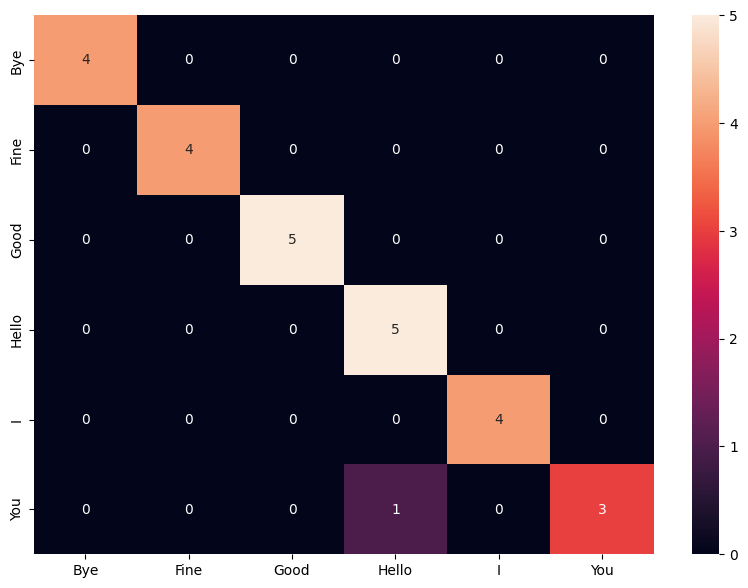

In [50]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn


array = confusion_matrix(ytrue, yhat)
df_cm = pd.DataFrame(array, index = [i for i in actions],
                  columns = [i for i in actions])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# 11. Test in Real Time

In [51]:
from scipy import stats
import threading
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [52]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num%3], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    # for num, prob in enumerate(res[6:]):
    #     cv2.rectangle(output_frame, (input_frame.shape[1]-120,60+num*40), (input_frame.shape[1]-120+int(prob*100), 90+num*40), colors[num%3], -1)
    #     cv2.putText(output_frame, actions[num+6], (input_frame.shape[1]-120, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [53]:
path_weight = './weights_1680488284.1119833.h5'
model = tf.keras.models.load_model(path_weight)

In [54]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-sequence_length:]
        
        if len(sequence) == sequence_length:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
                        sequence = []


            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,20), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 1s 561ms/step
Fine
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solut

In [ ]:
cap.release()
cv2.destroyAllWindows()